This notebook acquires data to measure the gain of the SiPM. It sets the overvoltage and then takes scope and MCA data with the Red Pitaya. The scope is setup to trigger on the LED.

In [1]:
import numpy as np
import time,datetime
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
plt.style.use('../../style.mplstyle')
import sys 
sys.path.append("../../devices")
sys.path.append("../../RedPitaya")
from datetime import datetime
import pyautogui
from ipywidgets import IntProgress

In [9]:
#### set data taking parameters here #####

save_dir = "" ## name of director to save, leave empty to use todays date as default
make_plots = True ## make diagnostic plots

breakdown_voltage = 27.38 ## Volts, breakdown to sweep keithley relative to
ov_list = np.arange(2, 7, 0.5) ## Volts, list of overvoltages to sweep

instr_to_sweep = 'keith' ## instrument to sweep over (must be 'keith' or 'synth')

red_pitaya_channel = 2 ## channel for the analog signal in the RP (1 or 2), used for MCA presumably after shaper
wf_chan_list = [1,2] ## list of RP channels to acquire waveforms for

num_scope_files=10 ## number of files to save the scope traces in
num_scope_traces = 200 ## number of traces at each overvoltage
num_mca_events = 1000 ## number of MCA pulses in the histogram
LED_flashing_rate = 4000 ## Hz, rate at which to pulse LED

In [10]:
## setup directories for saving data
def setup_save_dir(save_dir):

    if len(save_dir) > 0:
        path = "C:/Data/{}/".format(save_dir)
    else:
        date = datetime.today().strftime('%Y%m%d')
        subdir = ''
        path = "C:/Data/{}/{}/".format(date,subdir)
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    return path

In [11]:
## import instrument control as needed
from pitaya import RedPitaya
from functiongenerator import AFG2225
from picoammeter import Keithley6487
from powersupply import NGE100
import redpitaya_mca as mca

In [14]:
nge = NGE100('USB0::0x0AAD::0x0197::5601.1414k03-100771::INSTR')
pico = Keithley6487('ASRL9::INSTR')
func = AFG2225('ASRL19::INSTR')

In [15]:
## turn on 24 Volts to power the cremat pre-amplifier
output_channel = 1 ## channel to turn on
output_voltage = 24 # Volts
nge.output(ch=output_channel, state=False)
nge.voltage(ch=output_channel, volt=output_voltage)
nge.output(ch=output_channel, state=True)

In [16]:
# set the function generator to trigger the LED
synth_channel = 2
pulse_frequency = LED_flashing_rate ## Hz, rate of pulses
pulse_amplitude = 2.0 ## V, voltage for driving LED
amplitude_offset = pulse_amplitude/2.0 #pulse_amplitude/2 ## V, offset to give positive going pulse

func.set_frequency(synth_channel, pulse_frequency)
func.set_amplitude(synth_channel, pulse_amplitude)
func.set_offset(synth_channel, amplitude_offset)
func.set_output_load(synth_channel, "HZ") ## make sure the channel is set for high impedance
func.set_output_onoff(synth_channel, 1) ## turn on channel

## set up channel 1 on the synth as a trigger
synth_trig_channel = 1
func.set_amplitude(synth_trig_channel, 5) ## set 5V TTL
func.set_offset(synth_trig_channel, 2.5)
func.set_output_load(synth_trig_channel, "HZ") ## make sure the channel is set for high impedance
func.set_output_onoff(synth_trig_channel, 1) ## turn on channel
## couple to same freq as led channel
func.couple_channel(synth_trig_channel,'on')

In [17]:
## setup the Keithley and turn it on to the breakdown voltage so it starts ramping up

keithley_time_delay = 5 ## seconds, time to wait for the keithley to stabilize at a given voltage

if(instr_to_sweep == 'keith'):
    pico.voltage_source_state(0) ## turn off source
    pico.voltage_source_range(breakdown_voltage+np.max(ov_list)) ## set the range to accomodate the highest voltage needed
    pico.voltage(breakdown_voltage) ## set to breakdown
    pico.voltage_source_state(1) ## turn on source
    time.sleep(keithley_time_delay) ## wait for the voltage to ramp up
pico.voltage(30) ## set to breakdown

In [23]:
## helper function to take waveform data

def get_waveform_data(rp, chan, num_wfs, rp_size, trig='ext', trig_params = {'ch': 2, 'level': 20, 'delay': 0}):
    
    wvf_array=[]
    bar = IntProgress(min=0, max=num_wfs)
    display.display(bar)
    
    for wf_idx in range(num_wfs):
        bar.value += 1
        
        rp.configure(dec_fac=2)
        rp.start()
        
        if trig == 'ext':
            rp.ext_trigger(delay=trig_params['delay'])
        elif trig in [1,2]:
            rp.trigger(**trig_params)
        else:
            print("Trigger must be '''ext''' or 1,2 for channel")
            return None

        t, data = rp.acquire(ch=chan, size=rp_size, ascii=True)
        wvf_array.append(data)

    return np.array(wvf_array), t

!!!! Before running this cell make sure the SCPI server is running !!!

Acquiring 50 waveforms for OV 0.1, file number 0 of 10: 


IntProgress(value=0, max=50)

IntProgress(value=0, max=50)

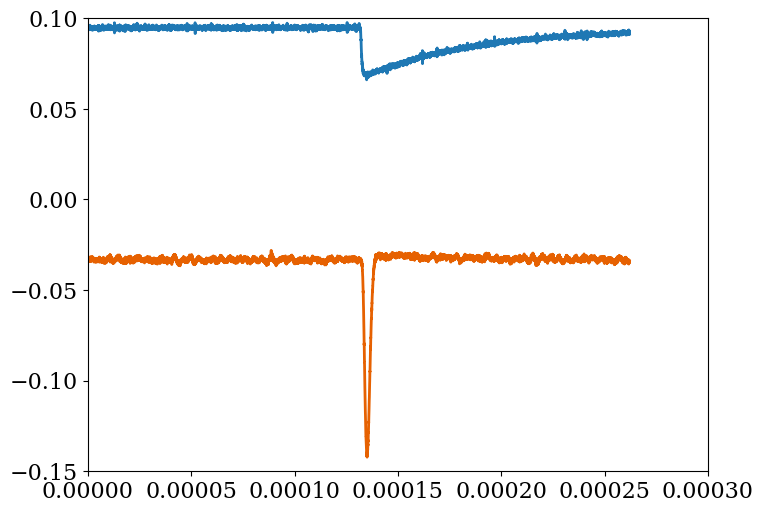

Acquiring 50 waveforms for OV 0.1, file number 1 of 10: 


IntProgress(value=0, max=50)

IntProgress(value=0, max=50)

Acquiring 50 waveforms for OV 0.1, file number 2 of 10: 


IntProgress(value=0, max=50)

IntProgress(value=0, max=50)

Acquiring 50 waveforms for OV 0.1, file number 3 of 10: 


IntProgress(value=0, max=50)

IntProgress(value=0, max=50)

Acquiring 50 waveforms for OV 0.1, file number 4 of 10: 


IntProgress(value=0, max=50)

IntProgress(value=0, max=50)

KeyboardInterrupt: 

In [27]:
## loop over overvoltages, and set the keithley. then take scope and MCA data as desired

#######################
save_dir = r"20220628\vacuum_tests"

breakdown_voltage = 0 #27.38 ## Volts, breakdown to sweep keithley relative to
ov_list = np.arange(0.1, 1, 0.1) ## Volts, list of overvoltages to sweep

instr_to_sweep = 'synth' ## instrument to sweep over (must be 'keith' or 'synth')
num_scope_files = 10 ## number of files to save the scope traces in
num_scope_traces = 50 ## number of traces at each overvoltage

rp_size = 16384 ## number of samples to acquire
rp_delay = 0 #8192/2 ## trigger delay relative to start of the waveform
#######################

red = RedPitaya('172.28.175.57', username='root', password='root')

## warn about overwriting files
path = setup_save_dir(save_dir)
if( os.path.isfile(os.path.join(path, 'wavefms_keith_{:.2f}OV_{}.h5'.format(breakdown_voltage+ov_list[0],0))) ):
    resp = pyautogui.confirm("File already exists, overwrite?")
    if( resp == "Cancel" ):
        raise KeyboardInterrupt
        
for ov in ov_list:

    ## set keithley to desired voltage (assumes wired reverse biased, so positive voltages):
    if(instr_to_sweep == 'keith'):
        pico.voltage(breakdown_voltage + ov) 
        time.sleep(keithley_time_delay) ## wait for voltage to ramp up
    elif(instr_to_sweep == 'synth'):
        current_amp =  ov #/ov_list[-1] #normalize to go up to 1 volt max
        func.set_offset(synth_channel, current_amp/2)
        func.set_amplitude(synth_channel, current_amp)
    else:
        print("Warning, not sweeping -- set instr_to_sweep to '''keith''' or '''synth''' ")
    
    for file_idx in range(num_scope_files):
        print("Acquiring %d waveforms for OV %.1f, file number %d of %d: "%(num_scope_traces, ov, file_idx+1, num_scope_files))
        wf_dict = {}
        for curr_chan in wf_chan_list:
            wf_data, t = get_waveform_data(red, curr_chan, num_scope_traces, rp_size)    
            wf_dict[curr_chan] = wf_data
        red.save(t, wf_dict, tag='wavefms_keith_{:.2f}OV_{}'.format(breakdown_voltage+ov,file_idx), path=path)

        if(make_plots and file_idx == 0):
            fig=plt.figure()
            for curr_chan in wf_chan_list:
                plt.plot(t, wf_dict[curr_chan][0,:])
            plt.show()

New test functions to get digital data from MCA code before filled into histogram

In [ ]:
red_mca = mca.mca()
ssh = red_mca.ssh_connect()
ssh.exec_command('reboot')

In [12]:
import sys 
sys.path.append("../../RedPitaya")
import redpitaya_mca as mca
import importlib 
import matplotlib
importlib.reload(mca)

<module 'redpitaya_mca' from '../../RedPitaya\\redpitaya_mca.py'>

In [13]:
red_mca = mca.mca()
ssh = red_mca.ssh_connect()

In [14]:
length = 65536
nbytes = 2
chan = 1
dec = 4
freq = 125e6/dec
sample = 1/freq 
for x in range(10):
    #dred_mca.command(2,chan)
    red_mca.config_scope(dec=dec, chan=chan, trig_chan=chan, trig_slope=0, trig_mode=0, trig_level=10000)
    red_mca.acq_scope(dec=dec, chan=chan, trig_chan=chan, trig_slope=0, trig_mode=0, trig_level=10000, samples_pre=5000, samples_total=length, wait=1)
    for y in range(1):
        data = red_mca._socket.recv(length*nbytes*2)
        converted_data = []
        for i in range(int(len(data)/nbytes)):
            converted_data.append(int.from_bytes(data[(i*nbytes):((i+1)*nbytes)], byteorder='little', signed=True))
        print(len(converted_data))
        length = int(len(converted_data[0::2]))
        plt.plot(np.linspace(0,length*sample,length)*1e6, converted_data[0::2], zorder=10)
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Amplitude [ADC Units]')
plt.show() 

6237


NameError: name 'plt' is not defined

In [31]:
red_mca.stop_mca()
red_mca.close()

!!!! Before running this section, make sure to start the MCA app via the web interface !!!

In [37]:
def setup_mca_data(channel_to_use, integ_time=100, min_thresh=0):

    rp = mca.mca()

    rp.setup_mca(chan=channel_to_use, baseline_level=2**16-1000, dec=16, integ_time = integ_time, min_thresh=min_thresh)
    rp.reset_histo(chan=channel_to_use)
    rp.start_histo(chan=channel_to_use)

    return rp

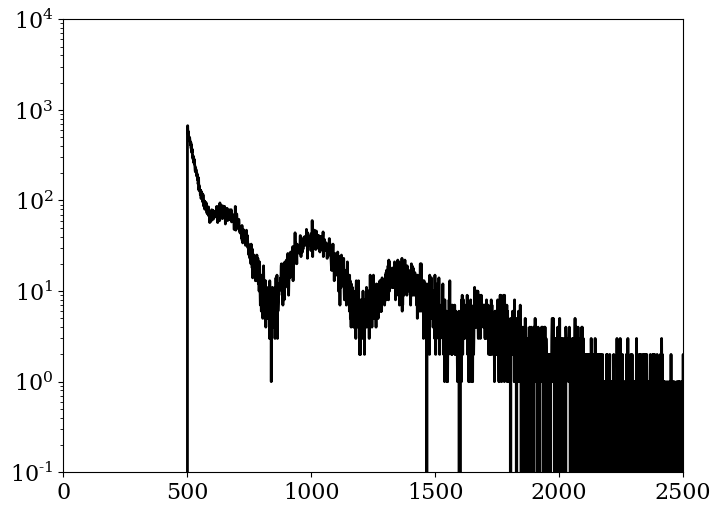

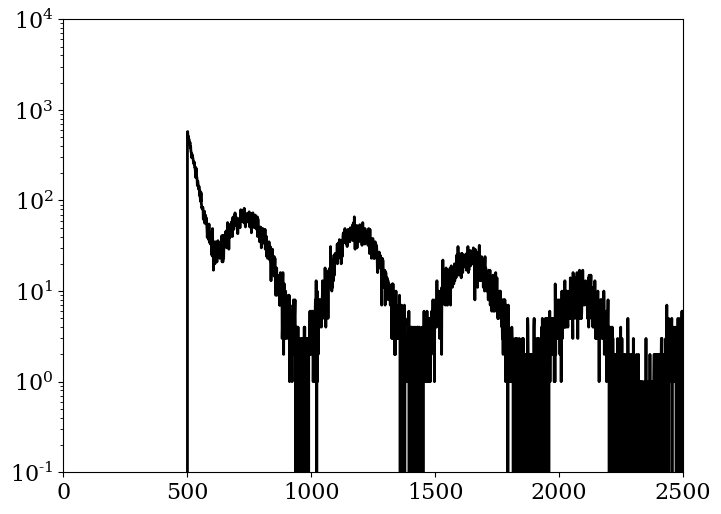

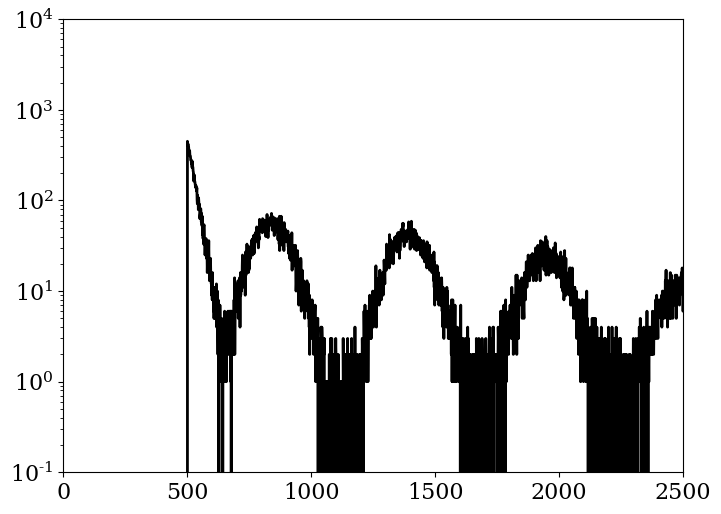

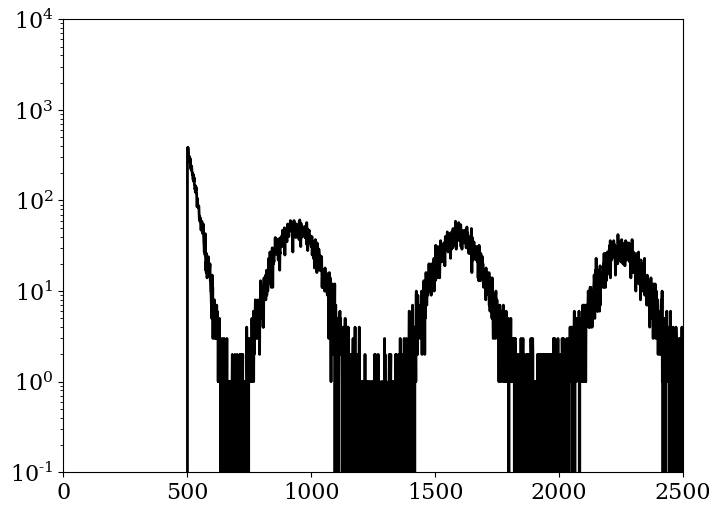

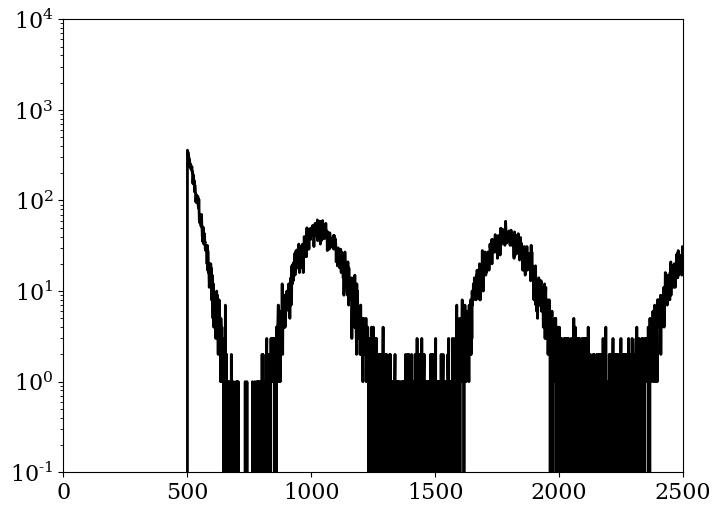

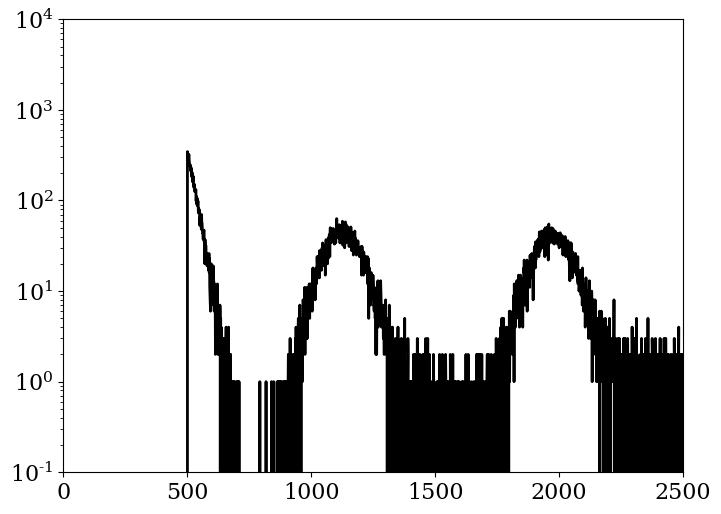

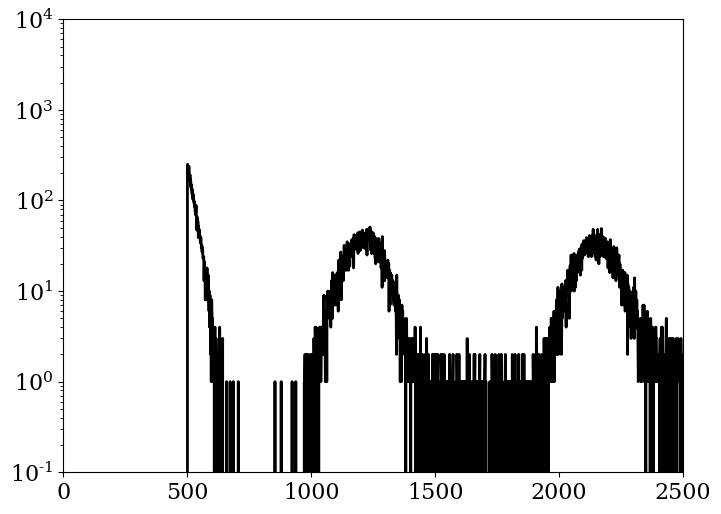

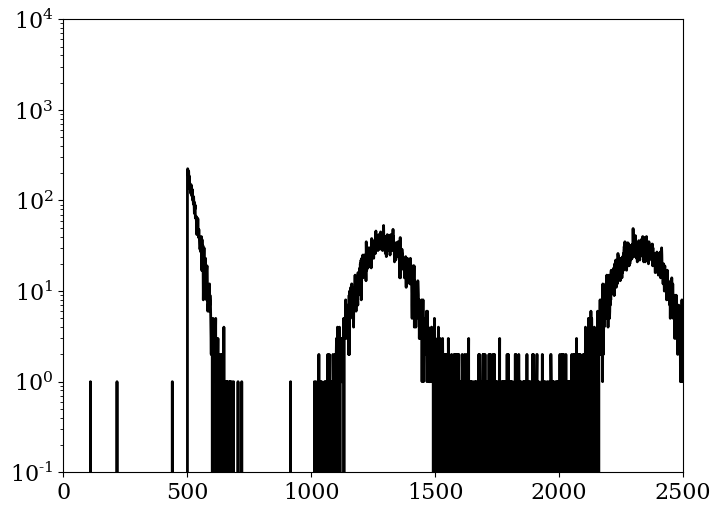

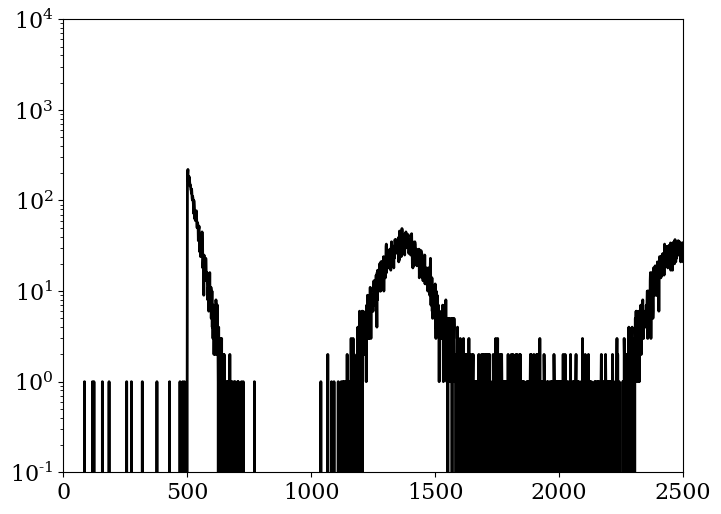

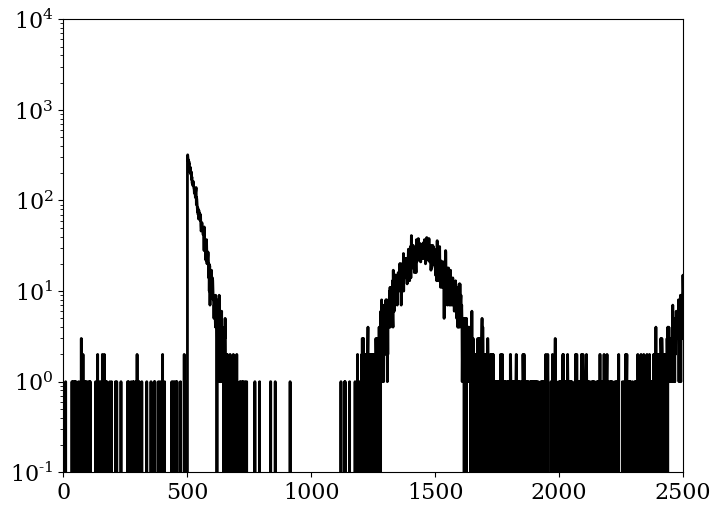

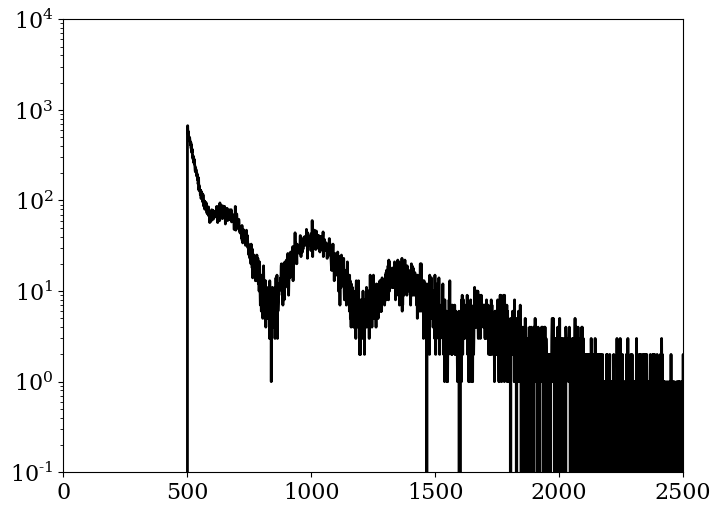

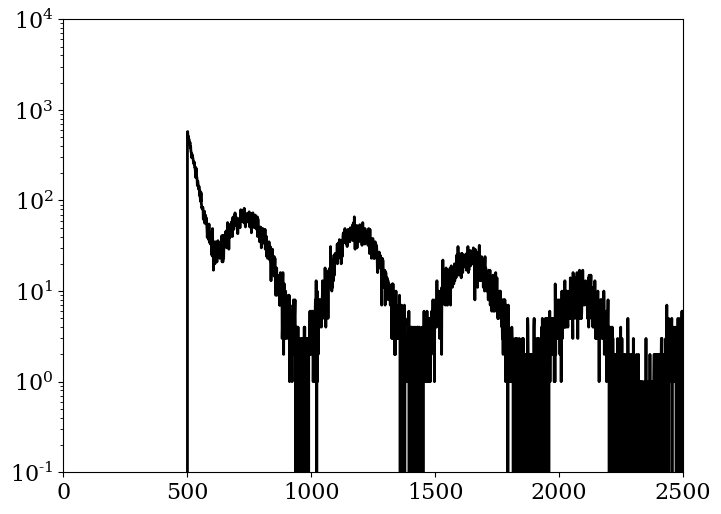

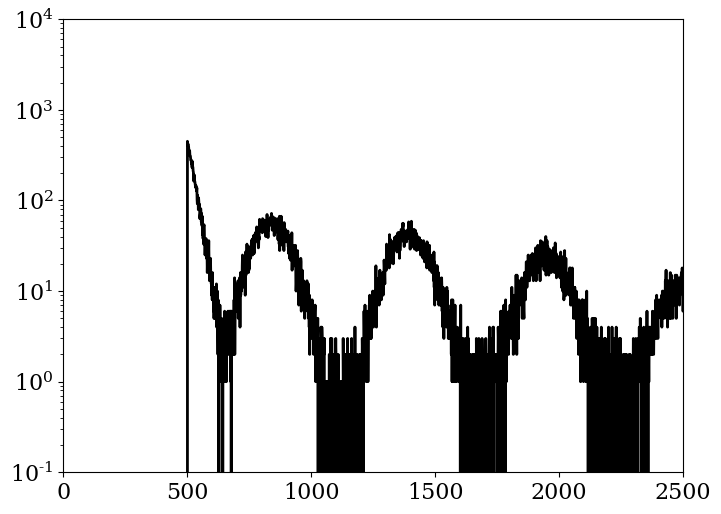

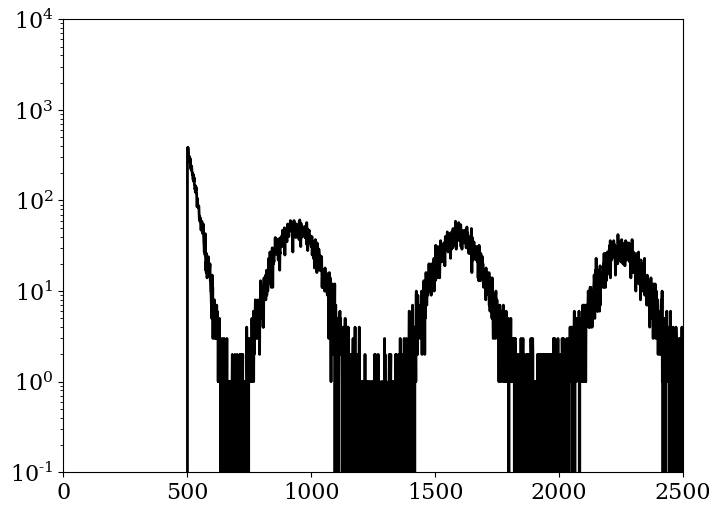

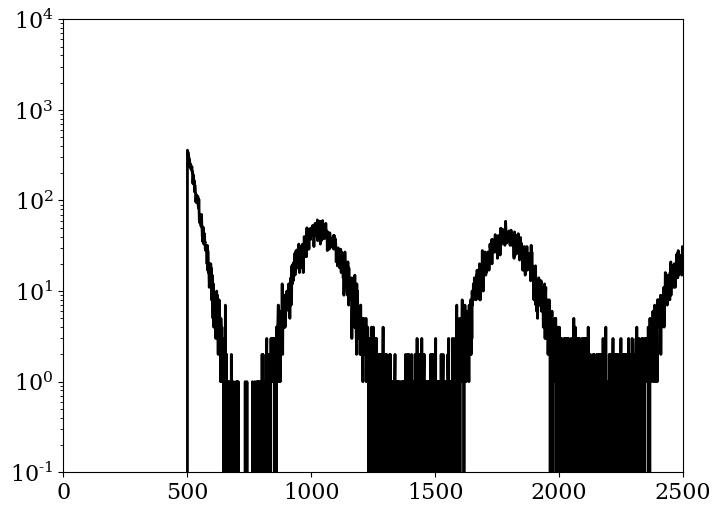

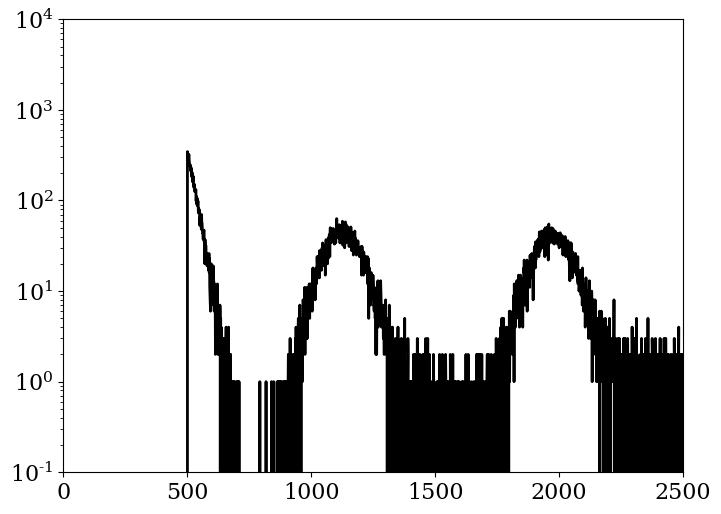

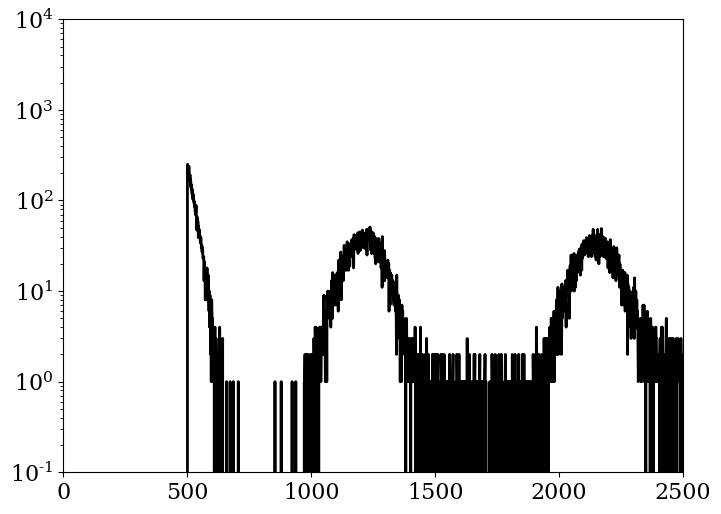

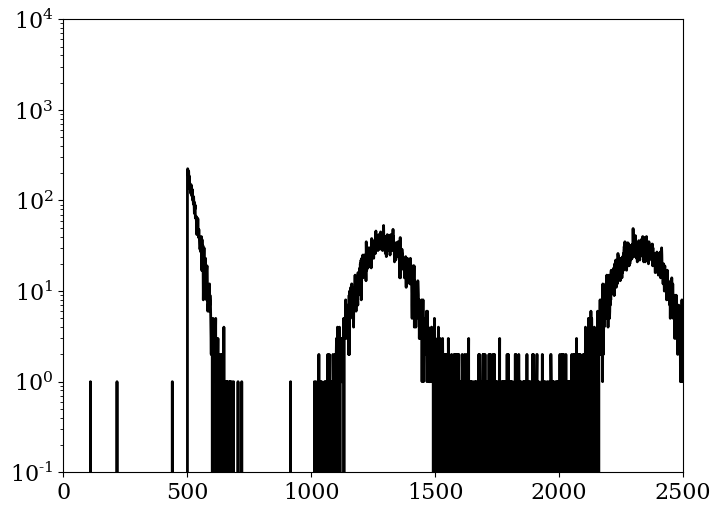

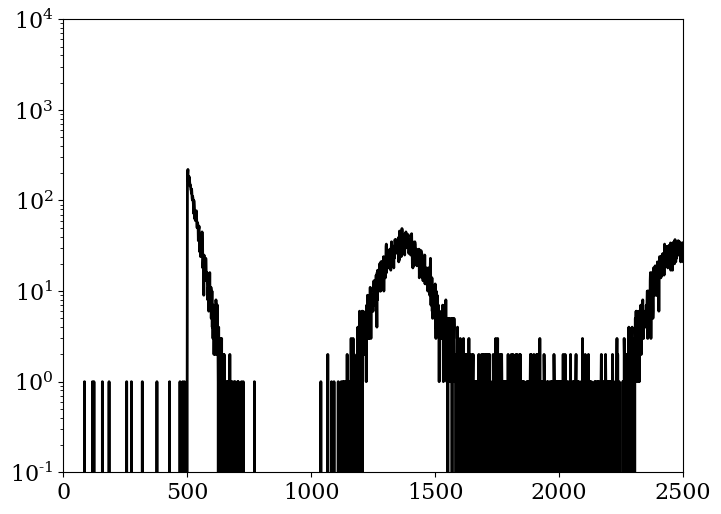

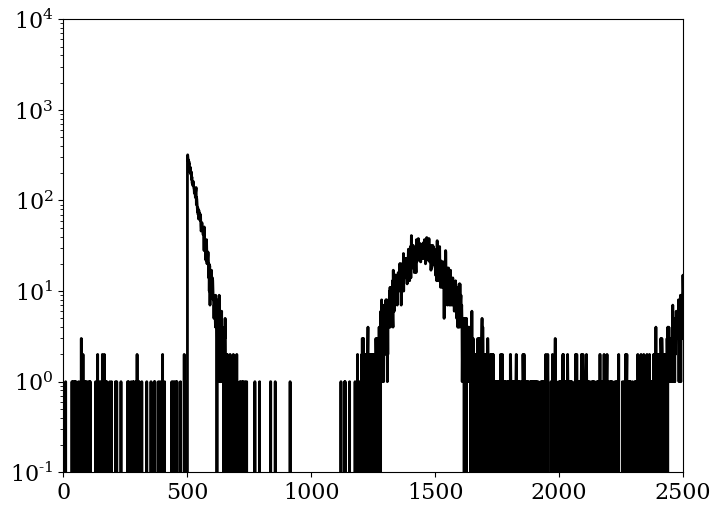

In [53]:
### should be two different settings for high SRS gain (gain data vs OV fully resolving 1 PE)
### and for low SRS gain (source data up to 100 PE)

## low gain data: SRS bandpass 100 Hz-300k Hz, gain = 20, unity gain shaper:  MCA params, dec=16, min_thresh=100 (cuts pedestal)
## high gain data: SRS bandpass 100 Hz -300k Hz, gain = 100, unity gain shaper:  MCA params, dec=16, min_thresh=500 (well sep from pedestal)

#######################
save_dir = r"20220629\vacuum_-109C_setpoint"

breakdown_voltage = 27.38 ## Volts, breakdown to sweep keithley relative to
ov_list = np.arange(2, 4.2, 0.2) ## Volts, list of overvoltages to sweep
#num_mca_events = 20000 ## number of events per file
time_per_file = 10 ## seconds
num_files_per_ov = 1

mca_thresh = 500 ## minimum threshold [ADC bins]

instr_to_sweep = 'keith' ## instrument to sweep over (must be 'keith' or 'synth')
#######################

int_time = int(time_per_file) #int(num_mca_events/LED_flashing_rate)

## warn about overwriting files
path = setup_save_dir(save_dir)
#if( os.path.isfile(os.path.join(path, 'wavefms_keith_{:.2f}OV_{}.h5'.format(ov_list[0],0))) ):
#    resp = pyautogui.confirm("File already exists, overwrite?")
#    if( resp == "Cancel" ):
#        raise KeyboardInterrupt

for ov in ov_list:

    ## set keithley to desired voltage (assumes wired reverse biased, so positive voltages):
    if(instr_to_sweep == 'keith'):
        pico.voltage(breakdown_voltage + ov) 
        time.sleep(keithley_time_delay) ## wait for voltage to ramp up
    elif(instr_to_sweep == 'synth'):
        current_amp =  ov #/ov_list[-1] #normalize to go up to 1 volt max
        func.set_offset(synth_channel, current_amp/2)
        func.set_amplitude(synth_channel, current_amp)
    else:
        print("Warning, not sweeping -- set instr_to_sweep to '''keith''' or '''synth''' ")


    for fidx in range(num_files_per_ov):
        red_mca = setup_mca_data(channel_to_use=red_pitaya_channel-1, integ_time=time_per_file, min_thresh=mca_thresh) # 0 indexing for the channel, unlike above
        time.sleep(1) ## wait for setup to be ready -- otherwise it will read before buffer is full

        if(make_plots):
            fig=plt.figure()
            fig.patch.set_facecolor('white')
            hfig = display.display(fig, display_id=True)

        for i in range(int_time):
            dat = red_mca.read_histo_data(chan=1)
            #curr_time = red_mca.read_timer(chan=1)
            #print(curr_time)

            if(make_plots):
                plt.clf()
                plt.yscale('log')
                plt.plot(dat, color='k')
                plt.ylim(0.1,10000)
                plt.xlim(0,2500)
                hfig.update(fig)
            time.sleep(0.5) # adjust due to dead time

        red_mca.save(dat, ch=red_pitaya_channel, tag='mca_keith_{:.2f}OV_{}'.format(breakdown_voltage+ov, fidx), path=path)

        red_mca.close()